# Computer Vision: scikit-image + scikit-learn

![](python-logo.png)
![](logo.png)
![](scikit-learn-logo-small.png)

# Problema: 
## Classificar Imagens de Motociclistas
#### *Com capacete* 

#### *Sem capacete*


In [1]:
import numpy as np
from numpy import copy
import matplotlib.pyplot as plt
from skimage.io import imread_collection,imsave
from sklearn.model_selection import train_test_split
from glob import glob
from scipy.stats import randint as sp_randint
import time
from skimage.color import rgb2grey
from skimage.filters import threshold_otsu
from skimage.measure import label,regionprops
import copy
from scipy.stats.mstats_basic import skew, kurtosis

%matplotlib inline

# Read images from database

In [2]:
path = "/Users/romuere/Dropbox/MTAP/databases/database2_raw_data/"

In [3]:
comcapacete = glob(path+'comcapacete/*.png')

In [4]:
semcapacete = glob(path+'semcapacete/*.png')

In [5]:
images_cc = imread_collection(comcapacete)
images_sc = imread_collection(semcapacete)

# Segmentation

In [6]:
def segmentation(im):
    '''Recebe uma imagem calcula limiar de otsu e fazer o 
       recorte obdecendo a região resultante desse limiar'''
    
    grey_image = rgb2grey(im)
    otsu = threshold_otsu(grey_image)
    im_ = grey_image < otsu 
    
    n_branco = np.sum(im_ == 1)
    n_preto = np.sum(im_ == 0)
    if n_branco > n_preto:
        im_ = 1-im_
    
    label_img = label(im_, connectivity = grey_image.ndim)#detecta regioes nao conectadas
    props = regionprops(label_img)#calcula propriedade importantes de cada regiao encontrada (ex. area)

    #Convert todas as regioes que possuem um valor de area menor que a maior area em background da imagem 
    area = np.asarray([props[i].area for i in range(len(props))])#area de cada regiao encontrada
    max_index = np.argmax(area)#index da maior regiao
    for i in range(len(props)):
        if(props[i].area < props[max_index].area):
            label_img[np.where(label_img == i+1)] = 0#regiao menor que a maior eh marcada como background
 
    #----------------recorte da regiao de interesse----------------#
    # Obtendo os limites verticais das imagens segmentadas 
    ymin = np.min(np.where(label_img != 0)[1])
    ymax = np.max(np.where(label_img != 0)[1])
    imagem_cortada = imagem[:,ymin:ymax,:]     
    return imagem_cortada

In [7]:
start = time.time()
for id_im,imagem in enumerate(images_cc):
    im_name = images_cc.files[id_im].split('/')[-1]
    imagem_segmentada = segmentation(imagem)
    imsave(path+'segmentacao/comcapacete/'+im_name,imagem_segmentada)

    #print(im_name)
for id_im,imagem in enumerate(images_sc):
    im_name = images_sc.files[id_im].split('/')[-1]
    imagem_segmentada = segmentation(imagem)
    imsave(path+'segmentacao/semcapacete/'+im_name,imagem_segmentada)
    #print(im_name)
    
end = time.time()
print(end - start)

0.9834959506988525


In [8]:
labels = np.concatenate((np.zeros(len(comcapacete)),np.ones(len(semcapacete))))

# Extracting Features using GLCM

In [9]:
path_segmentada = "/Users/romuere/Dropbox/MTAP/databases/database2_raw_data/segmentacao/"
comcapacete = glob(path_segmentada+'comcapacete/*.png')
semcapacete = glob(path_segmentada+'semcapacete/*.png')
images = imread_collection(comcapacete+semcapacete)

In [10]:
from skimage.feature import greycomatrix,greycoprops

### Parameter

- Distance
- Angle

In [11]:
d = 15

In [12]:
features = np.zeros((len(labels),18)) #6 features x 3 color channels
start = time.time()

for id_im,imagem in enumerate(images):
    for id_ch in range(3):
        matrix0 = greycomatrix(imagem[:,:,id_ch], [d], [0],normed=True)
        matrix1 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/4],normed=True)
        matrix2 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/2],normed=True)
        matrix3 = greycomatrix(imagem[:,:,id_ch], [d], [3*np.pi/4],normed=True)
        matrix = (matrix0+matrix1+matrix2+matrix3)/4 
        props = np.zeros((6))
        props[0] = greycoprops(matrix,'contrast')
        props[1] = greycoprops(matrix,'dissimilarity')
        props[2] = greycoprops(matrix,'homogeneity')
        props[3] = greycoprops(matrix,'energy')
        props[4] = greycoprops(matrix,'correlation')
        props[5] = greycoprops(matrix,'ASM')
        features[id_im,id_ch*6:(id_ch+1)*6] = props

end = time.time()
print(end - start)

4.67635178565979


# Split Data

In [13]:
train = 0.5
test = 1-train

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test)

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix,accuracy_score
from sklearn.svm import SVC


In [23]:
#Random Forest Parameter Estimation
def rf_parameter_estimation(xEst, yEst):
    
    clf = RandomForestClassifier(n_estimators=20)    
    # specify parameters and distributions to sample from
    hyperparameters = {"n_estimators": range(10,1000,50),
                  "max_depth": range(1,100),
                  "max_features": sp_randint(1, xEst.shape[1]),
                  "min_samples_split": sp_randint(1, xEst.shape[1]),
                  "min_samples_leaf": sp_randint(1, xEst.shape[1]),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
    
    
    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                       n_iter=n_iter_search,scoring=make_scorer(accuracy_score))
    
    
    random_search.fit(xEst, yEst)
    report(random_search.cv_results_)
    return random_search.best_params_

#SVM Parameter Estimation
def svm_parameter_estimation(xEst, yEst):
    
    hyperparameters = {'gamma': [1e-1, 1e-2,1e-3, 1e-4],'C': [1, 10, 100, 1000]}
    
    clf = SVC(kernel='rbf')
    # Run randomized search
    n_iter_search = 8
    random_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                       n_iter=n_iter_search,scoring=make_scorer(accuracy_score))    
    random_search.fit(xEst, yEst)

    report(random_search.cv_results_)
    return random_search.best_params_

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))

# Classification unsing all features

In [24]:
start = time.time()

parameters = rf_parameter_estimation(X_train, y_train)
c_rf = RandomForestClassifier(**parameters)
c_rf.fit(X_train,y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)

end = time.time()
print(end - start)

Model with rank: 1
Mean validation score: 0.811 (std: 0.077)
Parameters: {'n_estimators': 110, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_features': 10, 'criterion': 'gini', 'max_depth': 16, 'bootstrap': False}
Model with rank: 1
Mean validation score: 0.811 (std: 0.077)
Parameters: {'n_estimators': 410, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 5, 'criterion': 'gini', 'max_depth': 97, 'bootstrap': False}
Model with rank: 3
Mean validation score: 0.803 (std: 0.072)
Parameters: {'n_estimators': 660, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 9, 'criterion': 'entropy', 'max_depth': 84, 'bootstrap': False}
39.847474813461304


In [19]:
print('Random Forest Accuracy: ',acc_rf)

Random Forest Accuracy:  0.828125


In [31]:
start = time.time()

parameters = svm_parameter_estimation(X_train, y_train)
c_svm = SVC(**parameters)
c_svm.fit(X_train,y_train)
pred = c_svm.predict(X_test)
acc_svm = accuracy_score(y_test, pred)

end = time.time()
print(end - start)

Model with rank: 1
Mean validation score: 0.575 (std: 0.005)
Parameters: {'C': 1000, 'gamma': 0.1}
Model with rank: 1
Mean validation score: 0.575 (std: 0.005)
Parameters: {'C': 1, 'gamma': 0.01}
Model with rank: 1
Mean validation score: 0.575 (std: 0.005)
Parameters: {'C': 100, 'gamma': 0.01}
Model with rank: 1
Mean validation score: 0.575 (std: 0.005)
Parameters: {'C': 10, 'gamma': 0.01}
Model with rank: 1
Mean validation score: 0.575 (std: 0.005)
Parameters: {'C': 10, 'gamma': 0.001}
Model with rank: 1
Mean validation score: 0.575 (std: 0.005)
Parameters: {'C': 1000, 'gamma': 0.001}
0.06936192512512207


In [32]:
parameters

{'C': 1000, 'gamma': 0.1}

In [33]:
print('Support Vector Machine Accuracy: ',acc_svm)

Support Vector Machine Accuracy:  0.6171875


# Classification using PCA

In [34]:
from sklearn.decomposition import PCA

In [35]:
components = [2,4,8,10,12]

In [36]:
def pca(X_train, X_test,y_train, n_comp):
    """
    PCA transformation for using a 'training' set and a 'testing' set
    """
    pca = PCA(n_components=n_comp)
    pca.fit(X_train,y_train)
    transform = pca.transform(X_test)
    #print(pca.explained_variance_ratio_)
    return transform

In [37]:
results_rf = np.zeros(5)
results_svm = np.zeros(5)

start = time.time()
for id_comp,comp in enumerate(components):
    
    print('-------------','n comp. = ',comp,'-------------')
    
    X_train_pca = pca(X_train,X_train,y_train,comp)
    X_test_pca = pca(X_train,X_test,y_train,comp)
    #RF
    parameters = rf_parameter_estimation(X_train_pca, y_train)
    c_rf = RandomForestClassifier(**parameters)
    c_rf.fit(X_train_pca,y_train)
    pred = c_rf.predict(X_test_pca)
    acc = accuracy_score(y_test, pred)
    results_rf[id_comp] = acc
    
    print('-------------------------------------------------')
    
    parameters = svm_parameter_estimation(X_train_pca, y_train)
    c_svm = SVC(**parameters)
    c_svm.fit(X_train_pca,y_train)
    pred = c_svm.predict(X_test_pca)
    acc = accuracy_score(y_test, pred)
    results_svm[id_comp] = acc
    
end = time.time()
print(end - start)

------------- n comp. =  2 -------------
Model with rank: 1
Mean validation score: 0.598 (std: 0.023)
Parameters: {'n_estimators': 760, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_features': 1, 'criterion': 'gini', 'max_depth': 1, 'bootstrap': True}
Model with rank: 2
Mean validation score: 0.559 (std: 0.093)
Parameters: {'n_estimators': 310, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_features': 1, 'criterion': 'entropy', 'max_depth': 10, 'bootstrap': False}
Model with rank: 2
Mean validation score: 0.559 (std: 0.059)
Parameters: {'n_estimators': 260, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_features': 1, 'criterion': 'entropy', 'max_depth': 35, 'bootstrap': False}
-------------------------------------------------
Model with rank: 1
Mean validation score: 0.575 (std: 0.005)
Parameters: {'C': 1, 'gamma': 0.01}
Model with rank: 1
Mean validation score: 0.575 (std: 0.005)
Parameters: {'C': 1, 'gamma': 0.001}
Model with rank: 1
Mean validation score: 0.575 (std:

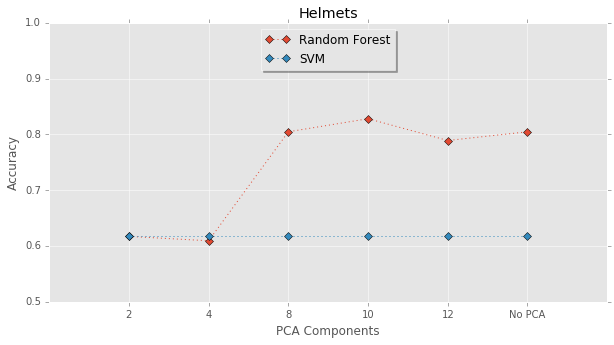

In [38]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (10,5),dpi=400)
ax = plt.subplot(111)
ax.plot(range(1,7),np.concatenate((results_rf,[acc_rf]),axis=0),marker = 'D',linestyle = ':',label = 'Random Forest')
ax.plot(range(1,7),np.concatenate((results_svm,[acc_svm]),axis=0),marker = 'D',linestyle = ':',label = 'SVM')
ax.set_xlim([0,7])
ax.set_xlabel('PCA Components')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(1,7))
ax.set_xticklabels(['2','4','8','10','12','No PCA'])
ax.set_ylim([0.5,1])
ax.set_title('Helmets')
legend = ax.legend(loc='upper center', shadow=True)

In [42]:
fig.savefig('/Users/romuere/pca.png')

In [43]:
results_svm

array([ 0.6171875,  0.6171875,  0.6171875,  0.6171875,  0.6171875])